# Retail Root Cause Analysis

## Setup and Import

In [69]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(".."))

# Import custom utility functions
from src.utils import setup_kaggle_api, download_kaggle_dataset, load_events_csv

# Set Display Options
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [ ]:
# Setup Kaggle API and download the dataset
setup_kaggle_api("../kaggle.json")
download_kaggle_dataset("retailrocket/ecommerce-dataset", dest_dir="../data")

## Data Exploration and Analysis

In [ ]:
# Load the events CSV file into a DataFrame
events_df = load_events_csv("../data/events.csv")
events_df.head()

,timestamp,visitorid,event,itemid,transactionid,date,hour
0,2015-06-02 05:02:12.117,257597,view,355908,NaN,2015-06-02,5
1,2015-06-02 05:50:14.164,992329,view,248676,NaN,2015-06-02,5
2,2015-06-02 05:13:19.827,111016,view,318965,NaN,2015-06-02,5
3,2015-06-02 05:12:35.914,483717,view,253185,NaN,2015-06-02,5
4,2015-06-02 05:02:17.106,951259,view,367447,NaN,2015-06-02,5


In [71]:
print("Event Types Distribution:")
print(events_df['event'].value_counts(normalize=True))

print("\nDate Range:", events_df['timestamp'].min(), "->", events_df['timestamp'].max())

Event Types Distribution:
event
view           0.966696
addtocart      0.025156
transaction    0.008148
Name: proportion, dtype: float64

Date Range: 2015-05-03 03:00:04.384000 -> 2015-09-18 02:59:47.788000


In [72]:
# Daily Active Users
daily_users = events_df.groupby('date')['visitorid'].nunique()

print("Average DAU:", daily_users.mean().round())

Average DAU: 11867.0


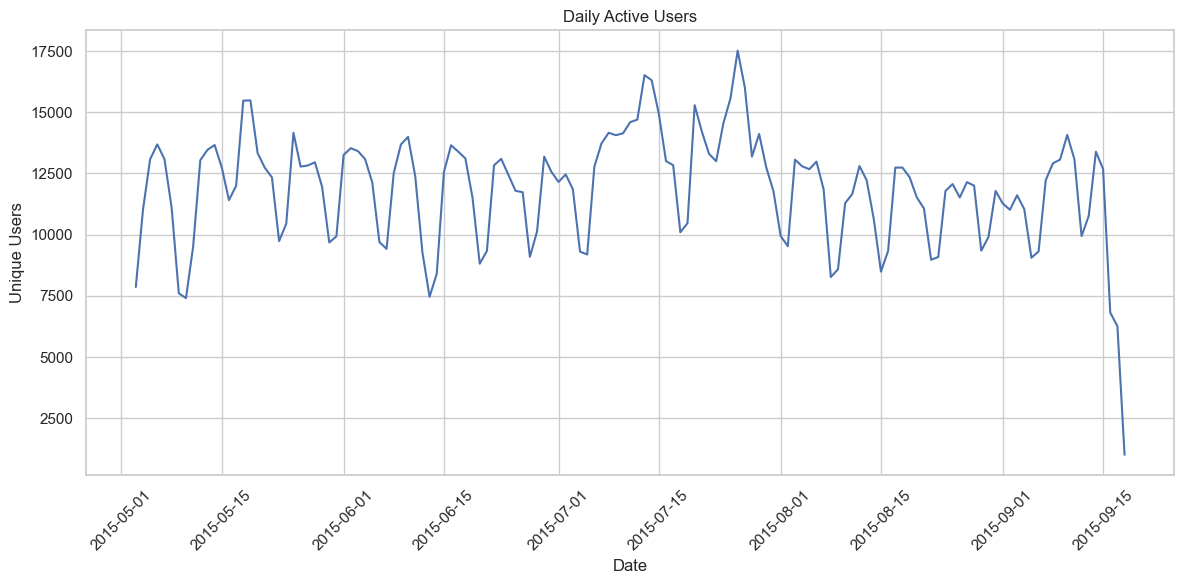

In [73]:
# Plot Daily Active Users
plt.figure(figsize=(12,6))
daily_users.plot()
plt.title("Daily Active Users")
plt.ylabel("Unique Users")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [74]:
# Monthly Active Users
events_df['date'] = pd.to_datetime(events_df['date'])  # Ensure 'date' is datetime
monthly_users = events_df.groupby(events_df['date'].dt.to_period('M'))['visitorid'].nunique()

print("Average MAU:", monthly_users.mean().round())

Average MAU: 296692.0


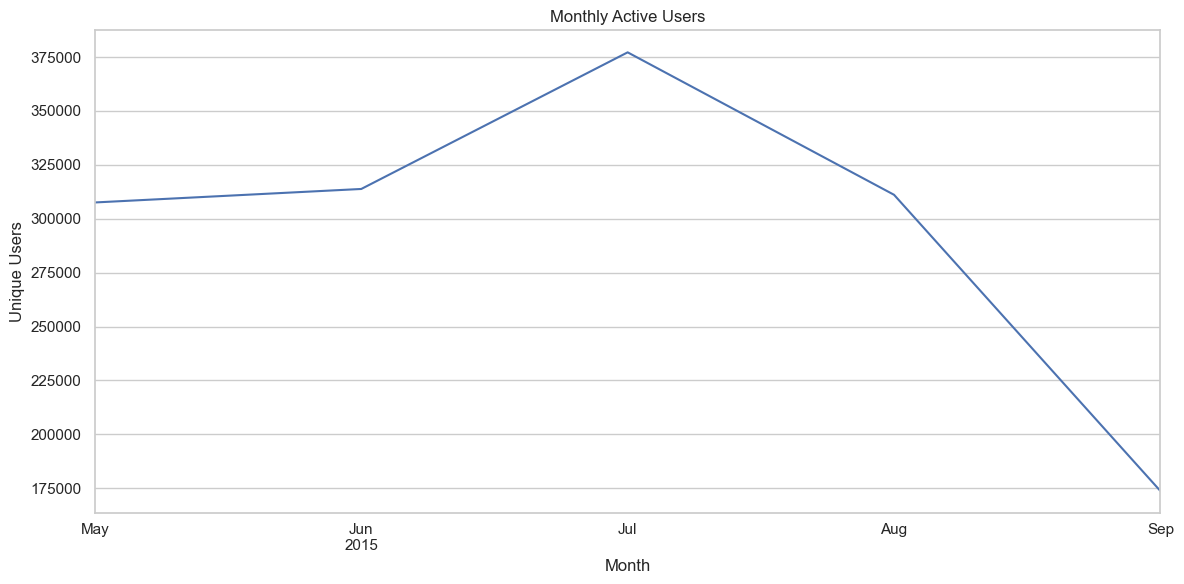

In [75]:
# Plot Monthly Active Users
plt.figure(figsize=(12,6))
monthly_users.plot()
plt.title("Monthly Active Users")
plt.ylabel("Unique Users")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [76]:
# Conversion Rate from View to Transaction
view_users = events_df[events_df['event'] == 'view']['visitorid'].nunique()
purchase_users = events_df[events_df['event'] == 'transaction']['visitorid'].nunique()

conversion_rate = 100 * purchase_users / view_users
print(f"Conversion Rate (view -> transaction): {conversion_rate:.2f}%")

Conversion Rate (view -> transaction): 0.83%


In [77]:
# Cart Abandonment Rate
cart_users = events_df[events_df['event'] == 'addtocart']['visitorid'].nunique()
abandonment_rate = 100 * (cart_users - purchase_users) / cart_users 

print(f"Cart Abandonment Rate: {abandonment_rate:.2f}%")

Cart Abandonment Rate: 68.93%


In [78]:
# Click-Through Rate (CTR)

# Click to Cart Rate (Intent of Purchase)
click_to_cart_rate = 100 * cart_users / view_users
print(f"Click to Cart Rate: {click_to_cart_rate:.2f}%")

# Click to Purchase Rate (Commit to Purchase)
commit_ctr = 100 * purchase_users / cart_users
print(f"Click to Purchase Rate: {commit_ctr:.2f}%")

Click to Cart Rate: 2.69%
Click to Purchase Rate: 31.07%


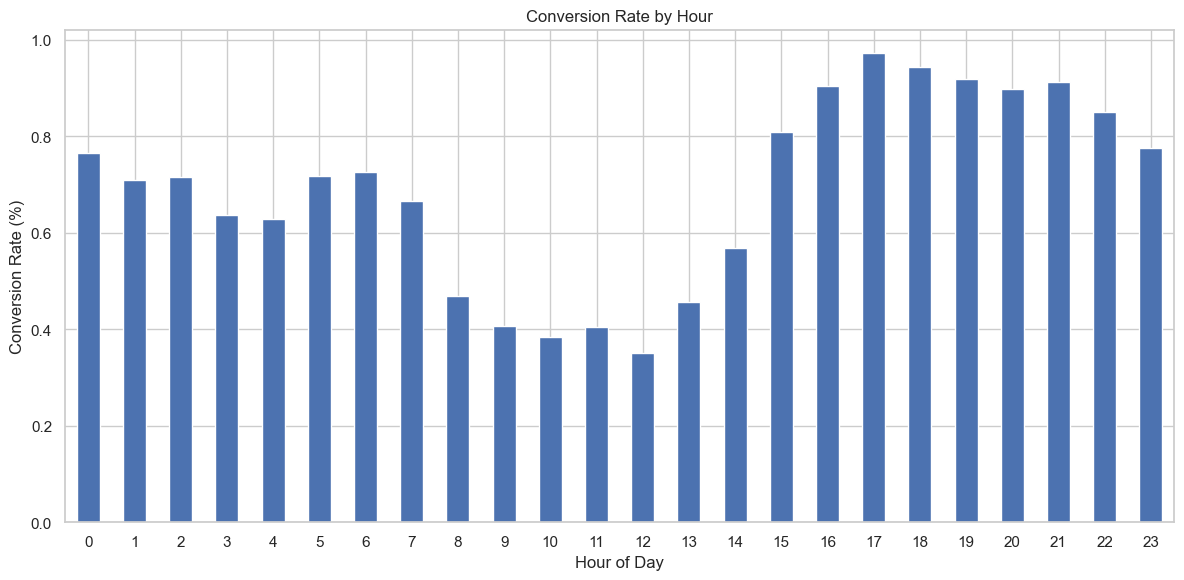

In [79]:
# Hourly Conversion Rate Analysis
hourly_views = events_df[events_df['event'] == 'view'].groupby('hour')['visitorid'].nunique()
hourly_purchases = events_df[events_df['event'] == 'transaction'].groupby('hour')['visitorid'].nunique()

hourly_cr = (hourly_purchases / hourly_views * 100).dropna()

hourly_cr.plot(kind='bar', figsize=(12,6), title="Conversion Rate by Hour")
plt.ylabel("Conversion Rate (%)")
plt.xlabel("Hour of Day")
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

In [80]:
# Session Depth Analysis
session_depth = events_df.groupby('visitorid').size()
print("Avg. Session Depth (engagements per user/session):", session_depth.mean().round(2))

Avg. Session Depth (engagements per user/session): 1.96


In [81]:
# View to Purchase Dropoff Rate
viewed_items = events_df[events_df['event'] == 'view'].groupby('itemid')['visitorid'].nunique()
bought_items = events_df[events_df['event'] == 'transaction'].groupby('itemid')['visitorid'].nunique()

item_dropoff = (viewed_items - bought_items).dropna().sort_values(ascending=False)

# Convert item_dropoff to a DataFrame for better visualization
item_dropoff_df = item_dropoff.reset_index()
item_dropoff_df.columns = ['itemid', 'dropoff_count']

# Print it in a readable and pretty format
print("\nTop 10 Items with Highest Dropoff Rate:")
print(item_dropoff_df.head(10).to_string(index=False))


Top 10 Items with Highest Dropoff Rate:
 itemid  dropoff_count
 219512         1346.0
 461686         1250.0
 384302         1129.0
 441668         1068.0
 309778         1038.0
 257040          955.0
 234255          951.0
 111530          915.0
 112782          878.0
 354233          846.0


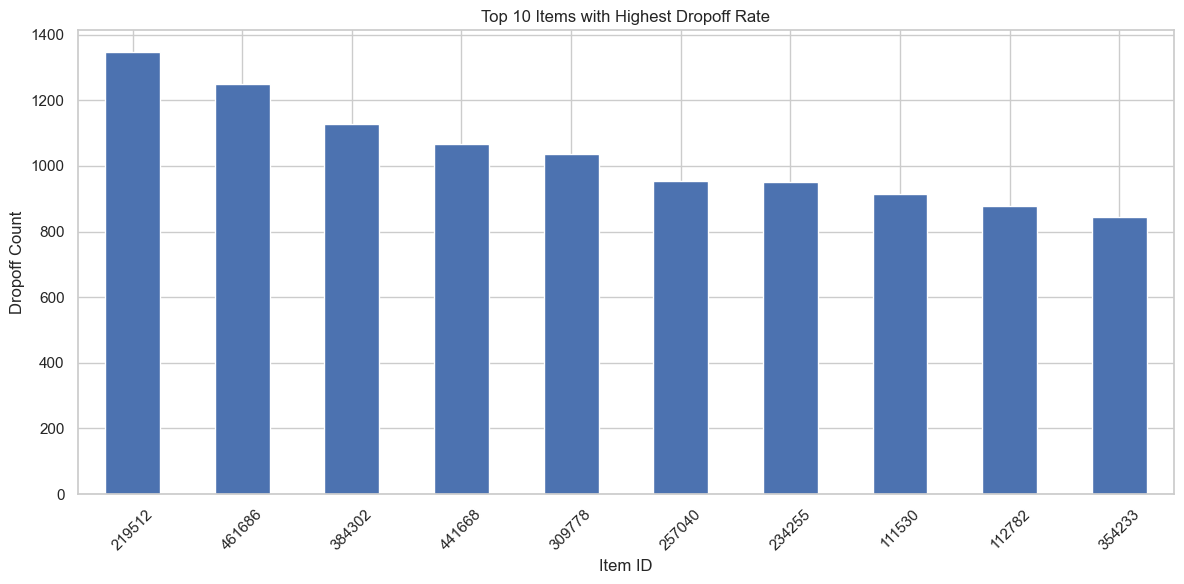

In [82]:
# Plot Item Dropoff
plt.figure(figsize=(12,6))
item_dropoff.head(10).plot(kind='bar')
plt.title("Top 10 Items with Highest Dropoff Rate")
plt.ylabel("Dropoff Count")
plt.xlabel("Item ID")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [83]:
part1 = pd.read_csv("../data/item_properties_part1.csv")
part2 = pd.read_csv("../data/item_properties_part2.csv")

all_props = pd.concat([part1, part2])
category_props = all_props[all_props['property'] == 'categoryid']

latest_category = category_props.sort_values('timestamp').drop_duplicates('itemid', keep='last')
latest_category = latest_category[['itemid', 'value']].rename(columns={'value': 'categoryid'})
latest_category['categoryid'] = latest_category['categoryid'].astype(int)

events_with_cat = events_df.merge(latest_category, on='itemid', how='left')
events_with_cat.reset_index().head(10)


,index,timestamp,visitorid,event,itemid,transactionid,date,hour,categoryid
0,0,2015-06-02 05:02:12.117,257597,view,355908,NaN,2015-06-02,5,1173.0
1,1,2015-06-02 05:50:14.164,992329,view,248676,NaN,2015-06-02,5,1231.0
2,2,2015-06-02 05:13:19.827,111016,view,318965,NaN,2015-06-02,5,NaN
3,3,2015-06-02 05:12:35.914,483717,view,253185,NaN,2015-06-02,5,914.0
4,4,2015-06-02 05:02:17.106,951259,view,367447,NaN,2015-06-02,5,491.0
5,5,2015-06-02 05:48:06.234,972639,view,22556,NaN,2015-06-02,5,1074.0
6,6,2015-06-02 05:12:03.240,810725,view,443030,NaN,2015-06-02,5,1098.0
7,7,2015-06-02 05:34:51.897,794181,view,439202,NaN,2015-06-02,5,1542.0
8,8,2015-06-02 04:54:59.221,824915,view,428805,NaN,2015-06-02,4,646.0
9,9,2015-06-02 05:00:04.592,339335,view,82389,NaN,2015-06-02,5,1404.0


In [84]:
# Number of Unique Visitors per Category
category_views = events_with_cat[events_with_cat['event'] == 'view'].groupby('categoryid')['visitorid'].nunique()
# Number of Unique Purchases per Category
category_purchases = events_with_cat[events_with_cat['event'] == 'transaction'].groupby('categoryid')['visitorid'].nunique()

# Calculate Conversion Rate per Category
category_cr = (category_purchases / category_views * 100).dropna().sort_values(ascending=False)

# Reset index and rename columns for clarity
category_cr = category_cr.reset_index()
category_cr.columns = ['category_id','conversion_rate']

# Top 10 Categories by Conversion Rate
category_cr.head(10)


,category_id,conversion_rate
0,555.0,27.272727
1,1013.0,19.354839
2,1467.0,12.500000
3,1215.0,11.111111
4,152.0,10.000000
5,1275.0,9.677419
6,1200.0,9.523810
7,4.0,9.375000
8,747.0,9.090909
9,1523.0,8.045977


In [85]:
# Load Category Tree
cat_tree = pd.read_csv("../data/category_tree.csv")
# Rename columns for clarity
cat_tree.reset_index()
cat_tree.columns = ['categoryid', 'parent_category']

# Merge Category Conversion Rate with Category Tree
category_cr = category_cr.merge(cat_tree, left_on='category_id', right_on='categoryid', how='left')
category_cr.head(10)

,category_id,conversion_rate,categoryid,parent_category
0,555.0,27.272727,555,104.0
1,1013.0,19.354839,1013,207.0
2,1467.0,12.500000,1467,164.0
3,1215.0,11.111111,1215,1424.0
4,152.0,10.000000,152,1329.0
5,1275.0,9.677419,1275,1618.0
6,1200.0,9.523810,1200,395.0
7,4.0,9.375000,4,1266.0
8,747.0,9.090909,747,287.0
9,1523.0,8.045977,1523,265.0


In [89]:
# Export the results to CSV files for Tableau Dashboard
category_cr.to_csv("../data/kpi_data/kpi_category_conversion.csv")
hourly_cr.to_csv("../data/kpi_data/kpi_hourly_cr.csv")
daily_users.to_csv("../data/kpi_data/kpi_dau.csv")
item_dropoff.head(10).to_csv("../data/kpi_data/kpi_top_dropped_items.csv")

In [ ]:
# Funnel Analysis
funnel_counts = events_df['event'].value_counts()
funnel_df = pd.DataFrame({
    'Stage': ['View', 'Add to Cart', 'Transaction'],
    'Users': [
        events_df[events_df['event'] == 'view']['visitorid'].nunique(),
        events_df[events_df['event'] == 'addtocart']['visitorid'].nunique(),
        events_df[events_df['event'] == 'transaction']['visitorid'].nunique()
    ]
})

# Export Funnel Data to CSV
funnel_df.to_csv("../data/kpi_data/kpi_funnel_summary.csv", index=False)

In [ ]:
# Summary of Key Performance Indicators (KPIs)
total_users = events_df['visitorid'].nunique()
view_users = events_df[events_df['event'] == 'view']['visitorid'].nunique()
cart_users = events_df[events_df['event'] == 'addtocart']['visitorid'].nunique()
purchase_users = events_df[events_df['event'] == 'transaction']['visitorid'].nunique()
session_depth = events_df.groupby('visitorid').size().mean()

# Create a summary DataFrame for KPIs
summary_df = pd.DataFrame({
    "KPI": ["Total Users", "Conversion Rate (%)", "Cart Abandonment Rate (%)", "Avg. Session Depth"],
    "Value": [
        total_users,
        round(100 * purchase_users / view_users, 2),
        round(100 * (cart_users - purchase_users) / cart_users, 2),
        round(session_depth, 2)
    ]
})

# Export Summary Data to CSV
summary_df.to_csv("../data/kpi_data/kpi_summary.csv", index=False)
